In [17]:
import re
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/fivecentsly/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/fivecentsly/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/fivecentsly/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [18]:
df_d = pd.read_csv('recipe_data/dinner_clean.csv')
df_d.shape

(958, 16)

In [19]:
df_l = pd.read_csv('recipe_data/lunch_clean.csv')
df_l.shape

(1017, 16)

In [20]:
df_2860 = pd.read_csv('recipe_data/ingredient_2860_clean.csv')
df_2860.shape

(2427, 30)

In [21]:
df_type = df_d.append(df_l)

In [22]:
df_type.drop(['Breakfast and Brunch', 'Dinners', 'Lunch'], axis=1, inplace=True)

In [23]:
df_2860.drop(['Beef', 'Beans and Legumes', 'Chicken Recipes', 'Game Meats',
              'Grains', 'Mushrooms', 'Pasta', 'Pork Recipes', 'Potatoes', 'Poultry',
              'Rice', 'Salmon', 'Seafood', 'Shrimp', 'Tofu and Tempeh', 'Turkey',
              'Vegetable Recipes', ], axis=1, inplace=True)

In [24]:
df_type.head(1)

,link,title,ratings,num_reviews,ingredients,servings,cook_time,calorie,fat_g,carb_g,protein_g,cholesterol_mg,sodium_mg
0,https://www.allrecipes.com/recipe/100195/baked...,Baked Haddock,4.59,731,"['3/4 cup milk', '2 teaspoons salt', '3/4 cup ...",4.0,25,325.0,15.7,17.0,27.7,103.0,1565.0


In [25]:
df_2860.head(1)

,link,title,ratings,num_reviews,ingredients,servings,cook_time,calorie,fat_g,carb_g,protein_g,cholesterol_mg,sodium_mg
0,https://www.allrecipes.com/recipe/100182/grand...,Grandpas Classic Coney Sauce,4.29,371,"['2 pounds ground beef', '1/2 cup chopped onio...",12.0,130,186.0,9.2,12.8,13.5,46.0,586.0


In [26]:
df = df_type.append(df_2860)
df.shape

(4402, 13)

In [27]:
# check duplicates
df.drop_duplicates('link', inplace=True)
df.duplicated().sum()

0

In [32]:
# check for duplicated titles
df.title.duplicated().sum()

1

In [36]:
df.drop_duplicates('title', inplace=True)
df.title.duplicated().sum()

0

In [37]:
df.shape

(3954, 13)

In [38]:
df.to_csv('recipe_clean.csv', index=False)

# Preprocess

In [38]:
df = df[['title', 'ingredients']]
df.head(1)

,title,ingredients
0,Baked Haddock,"3/4 cup milk,2 teaspoons salt,3/4 cup bread cr..."


In [39]:
# define a function to convert ingredients
def list_to_str(x):
    """
    Convert list to str
    """
    # extract list from str
    x = ast.literal_eval(x)
    
    # convert list to str
    x = ','.join(x)

    return x

In [40]:
# apply function to df
df.ingredients = df.ingredients.apply(list_to_str)
df.head(1)

SyntaxError: invalid syntax (<unknown>, line 1)

In [41]:
# create a new df with title as index
df_new = pd.DataFrame(df.ingredients.str.split(',').tolist(), index=df.title).stack()
df_new.head()

title           
Baked Haddock  0                       3/4 cup milk
               1                   2 teaspoons salt
               2               3/4 cup bread crumbs
               3     1/4 cup grated Parmesan cheese
               4    1/4 teaspoon ground dried thyme
dtype: object

In [42]:
# remove index
df_new = df_new.reset_index([0, 'title'])

# set column name
df_new.columns = ['title', 'ingredients']
df_new.head()

,title,ingredients
0,Baked Haddock,3/4 cup milk
1,Baked Haddock,2 teaspoons salt
2,Baked Haddock,3/4 cup bread crumbs
3,Baked Haddock,1/4 cup grated Parmesan cheese
4,Baked Haddock,1/4 teaspoon ground dried thyme


In [43]:
# define a function to clean ingredients
def clean_ingredients(x):
    """
    Clean ingredients
    """
    # remove punctuation and number
    x = re.sub(r'[^a-zA-Z]', ' ', x)
    
    # remove duplicate whitespace
    x = ' '.join(x.split())
    
    return x

In [44]:
# apply function to df
df_new.ingredients = df_new.ingredients.apply(clean_ingredients)
df_new.head()

,title,ingredients
0,Baked Haddock,cup milk
1,Baked Haddock,teaspoons salt
2,Baked Haddock,cup bread crumbs
3,Baked Haddock,cup grated Parmesan cheese
4,Baked Haddock,teaspoon ground dried thyme


In [45]:
# remove food or time units 
units = ['spoon','pound','cup','quart','ounce','pint','degree','dash','pinch','pack','halve','bunch']

for unit in units:
    expression = re.compile('\w*' + unit + '\w*')
    df_new.ingredients = df_new.ingredients.apply(lambda x: re.sub(expression, '', x).strip())
    
df_new.head()

,title,ingredients
0,Baked Haddock,milk
1,Baked Haddock,salt
2,Baked Haddock,bread crumbs
3,Baked Haddock,grated Parmesan cheese
4,Baked Haddock,ground dried thyme


In [46]:
# remove stopwords 
df_new.ingredients = df_new.ingredients.apply(lambda x: ' '.join([w.lower() for w in x.split(' ') if w.lower() not in stopwords.words('english')]))

In [47]:
# lemmatization
lemmatizer = WordNetLemmatizer()
df_new['ingredient'] = df_new.ingredients.apply(lambda x: ' '.join([lemmatizer.lemmatize(w) for w in x.split(' ')]))

df_new.head()

,title,ingredients,ingredient
0,Baked Haddock,milk,milk
1,Baked Haddock,salt,salt
2,Baked Haddock,bread crumbs,bread crumb
3,Baked Haddock,grated parmesan cheese,grated parmesan cheese
4,Baked Haddock,ground dried thyme,ground dried thyme


In [48]:
# remove recipe stopwords
recipe_stopwords = ['grated','ground','dried','fillet','melted','thinly','sliced','chopped','minced','fully','cooked',
                    'cut','dry','shredded','divided','optional','minced','fresh','peeled','pitted','finely','wedge',
                    'coarsely','e g','flaked','zested','low','canned','sodium','large','whole','scored','serving',
                    'piece','plus','soaked','inch','untreated','removed','diced','juiced','stemmed','cracked',
                    'coarse','fine','slice','beaten','mix','mixed','part','skim','crushed','clove','can','frozen',
                    'thawed','nonfat','container','lean','recipe','dish','scrubbed','all','purpose','thick','stalk',
                    'kosher','cored','milliliter','bottle','style','distilled','chop','drained','cubed','cube','pre',
                    'fluid','flavored','medium','jumbo','taste','blanched','crumbled','crumb','seasoned','boneless',
                    'thin','carton','substitute','dipping','homemade','hour','pushed','washed','small','gallon',
                    'refried','favorite','split','lightly','prepared','leaf','toasted','except','eat','rinsed','bite',
                    'size','color','baby','trimmed','cluster','box','quick','cooking','ripe','reduced','fat',
                    'refrigerated','pan','regular','healthy','free','pouch','chuck','mashed','layer','marinated',
                    'imported','room temperature','top','freshly','boiled','rub']

In [49]:
# remove recipe stopwords
df_new.ingredient = df_new.ingredient.apply(lambda x: ' '.join([w.lower() for w in x.split(' ') 
                                                                if w.lower() not in recipe_stopwords]))

df_new.head()

,title,ingredients,ingredient
0,Baked Haddock,milk,milk
1,Baked Haddock,salt,salt
2,Baked Haddock,bread crumbs,bread
3,Baked Haddock,grated parmesan cheese,parmesan cheese
4,Baked Haddock,ground dried thyme,thyme


In [50]:
# keep the rows with ingredient
df_new = df_new[df_new.ingredient != '']
df_new.shape

(43395, 3)

In [52]:
# check recipe vocabulary
vocab = dict()
for i in range(df_new.shape[0]):
    word = df_new.ingredient.iloc[i]
    if word not in vocab.keys():
        vocab[word] = 1
    else:
        vocab[word] += 1

In [53]:
# check total num of ingredients
len(list(vocab.keys()))

3688

In [62]:
# save df_new
df_new.to_csv('recipe_text.csv', index=False)

In [55]:
# create a df with word counts
df_count = pd.DataFrame(vocab, index=['count']).transpose().sort_values('count', ascending=False)
df_count = df_count.reset_index().rename(columns={'index': 'ingredient'})
df_count.head()

,ingredient,count
0,salt,1795
1,garlic,1458
2,onion,1361
3,black pepper,1220
4,olive oil,1085


In [56]:
# plot the most common ingredients
def plot_ingredient(df, top_n=10, figsize=(8,10)):
    plt.figure(figsize=figsize)
    
    count = df['count'].iloc[:top_n]
    ingred = df['ingredient'].iloc[:top_n]
    sns.barplot(x=count, y=ingred, palette='Reds_r')
    plt.title(f'{top_n} most common ingredients\n')
    plt.xlabel('Count')
    plt.ylabel('Ingredient')
    plt.show()

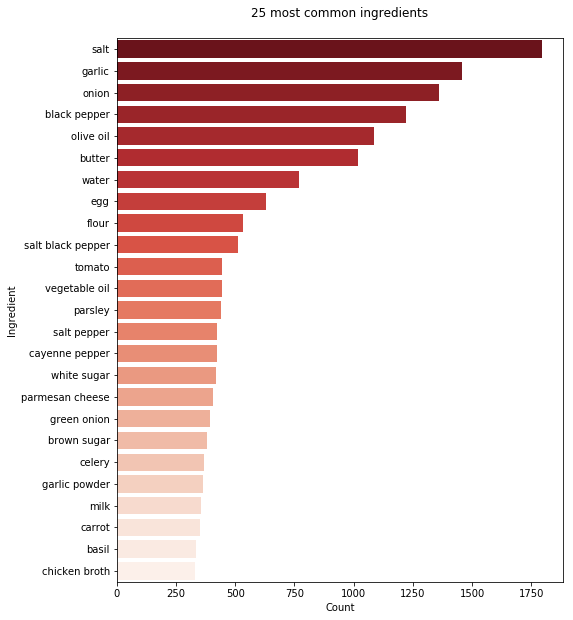

In [61]:
plot_ingredient(df_count, top_n=25)